In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import glob
import pickle
import pandas as pd
from scipy import special
import pyccl as ccl
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import pyccl as ccl
import clmm
from scipy import stats
from clmm import Cosmology

def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()

sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/likelihood/')
import model_completeness as comp
import model_purity as pur
import model_cluster_abundance as cl_count
import model_stacked_cluster_mass as cl_mass

sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/')
import class_richness_mass_relation as rm_relation

sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/pinocchio/')
import pinocchio_mass_richness_relation as sim_mr_rel
import pinocchio_binning_scheme as binning_scheme

In [2]:
log10m0, z0 = sim_mr_rel.log10m0, sim_mr_rel.z0
proxy_mu0, proxy_muz, proxy_mulog10m =  sim_mr_rel.proxy_mu0, sim_mr_rel.proxy_muz, sim_mr_rel.proxy_mulog10m
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  sim_mr_rel.proxy_sigma0, sim_mr_rel.proxy_sigmaz, sim_mr_rel.proxy_sigmalog10m
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]
sigma_wl_log10mass = 0.25/np.log(10)#sim_mr_rel.sigma_wl_log10mass
RM1 = rm_relation.Richness_mass_relation()
RM1.select(which = 'log_normal_poisson_scatter')

In [3]:
RM2 = rm_relation.Richness_mass_relation()
RM2.select(which = 'log_normal')

In [4]:
richness_grid = np.logspace(np.log10(0.0000001), np.log10(200), 310)

In [5]:
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]

In [6]:
z = 0.5

In [7]:
from scipy.stats import poisson

In [8]:
from scipy.integrate import quad
from math import factorial, sqrt, pi, log, exp
import matplotlib.pyplot as plt

def pdf_richness_mass_relation_GPC(k, mu, sigma):
    """
    Computes P(Y = k) where:
      - ln X ~ N(ln(mu), sigma^2)
      - Y | X ~ Poisson(X)
    """
    def integrand(lnx):
        x = np.exp(lnx)
        return np.exp(-x)* x**k * np.exp(-(lnx - mu)**2/(2*sigma**2)) / (sigma * np.sqrt(2 * pi))
    lnx_tab = np.linspace(mu-4*sigma, mu+3*sigma, 300)
    tab_integrand = integrand(lnx_tab)

    result = np.trapz(tab_integrand, lnx_tab)
    return result/factorial(k)

/tmp/ipykernel_53667/265289317.py:13: RuntimeWarning: overflow encountered in power
  return np.exp(-x)* x**k * np.exp(-(lnx - mu)**2/(2*sigma**2)) / (sigma * np.sqrt(2 * pi))


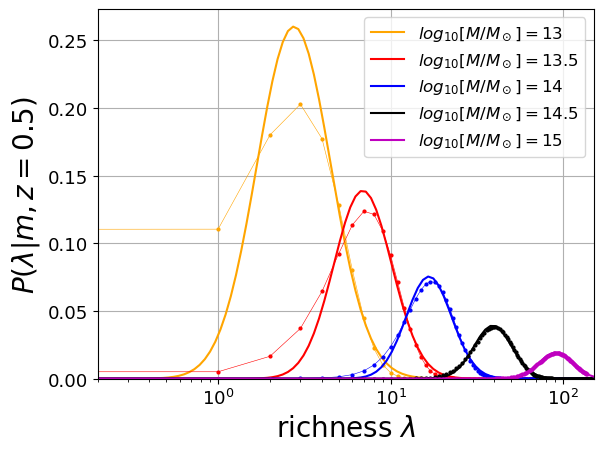

In [18]:
color = ['orange', 'r','b','k', 'm',]
for i, logm in enumerate([13, 13.5, 14, 14.5, 15]):
    mu_lnlambda = RM1.proxy_mu_f(logm, z, theta_rm)
    sigma_lnlambda = RM1.proxy_sigma_f(logm, z, theta_rm)
    richness_tab = np.arange(0, 150)
    y = [pdf_richness_mass_relation_GPC(k, mu_lnlambda, sigma_lnlambda) for k in richness_tab]
    plt.plot(richness_tab, y, 'o-', color = color[i], markersize=2, lw=0.4)

    y_log_normal_poisson_log_scatter = richness_grid* RM1.pdf_richness_mass_relation(richness_grid, logm, z, theta_rm)
    plt.plot(richness_grid, y_log_normal_poisson_log_scatter/richness_grid, '-', color = color[i], label = r'$log_{10}[M/M_\odot]=$'+str(logm))

plt.tick_params(axis='both', which = 'major', labelsize= 13)

plt.xscale('log')
plt.xlim(0.2, 150)
plt.ylim(0)
#plt.plot([], [], 'k',ls='dotted', label = r'log-normal $(\sigma_{\rm \ln\lambda, int}^2$)')
plt.legend(fontsize=12)
plt.ylabel(r'$P(\lambda|m,z=0.5)$', fontsize=20)
plt.xlabel(r'richness $\lambda$', fontsize=20)
plt.grid()
#plt.yscale('log')
#plt.savefig(f'/pbs/throng/lsst/users/cpayerne/capish/figures/impact_poisson_scatter_mass-richness_relation.png', dpi = 300, bbox_inches='tight', )